# Verticapy - Home First / Path of Care models
Integrate the HOME FIRST & Path of Care models into Vertica using the verticapy library


Tested a variety of input datas structures and data sources for model performance.
Found that liminting input data to in contract data and filling null enroll_start_period with the min stay admit month & filling nulls in period with the stay admit month led to much better model performance in the claims RA model & similar or very slightly worse performance in the OPS RA model  

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import pickle


from verticapy import *
import verticapy.stats as st
from verticapy.learn.delphi import AutoDataPrep
#from verticapy.learn.model_selection import *
from verticapy.learn.delphi import AutoML

import vertica_python
import time
import warnings

from datetime import datetime

warnings.filterwarnings("ignore")

In [2]:
#start notebook run timer
NBstart_time = time.time()

## Load Data

#### Load input data using vertica_python connection

In [3]:
#Read in Username
with open(r'C:\Users\JJFRASC\Documents\CCx Projects\Vertica_Extractions\vertica1.txt') as f:
    vertica1 = f.read()
    f.close()

#Read in Password
with open(r'C:\Users\JJFRASC\Documents\CCx Projects\Vertica_Extractions\vertica2.txt') as f:
    vertica2 = f.read()
    f.close()

In [4]:
# Build vertica connection
vert_str = {
            'host': 'P1VERTICA',
            #'host': 'D1VERTICA',
            'port': 5433,
            'user': vertica1,
            'password': vertica2,
            'database': 'P1DA01',
            #'database': 'D1DA01',
            'read_timeout': 600,
            'unicode_error': 'strict',
            'ssl': True
            }

In [5]:
#create vertica connection
vert_conn = vertica_python.connect(**vert_str)
cur = vert_conn.cursor()

# WILL NEED TO ADD (to where statement here) 'OR POC_RECOMMENDATION IS NULL' 
## (ONCE model reccs INTEGRATED INTO PDM)
This will ensure anyone who hasn't recieved a prediction yet gets one

In [6]:
%%time
#load only data for patients that are in HOS and haven't been discharged yet
data_forPreds = vdf_from_relation("(SELECT * FROM DATALAB_WORK_PRD.HomeFirst_Model_Inputs WHERE STAY_DISCHARGE_DATE IS NULL) x",
                cursor=cur)


Wall time: 3.28 s


## Model Training

In [7]:
#import model libarary

from verticapy.learn.linear_model import LogisticRegression
from verticapy.learn.ensemble import RandomForestClassifier
from verticapy.learn.tree import DummyTreeClassifier
#from verticapy.learn.naive_bayes import NaiveBayes
from verticapy.learn.ensemble import XGBoostClassifier
from verticapy.learn.tree import DecisionTreeClassifier
#from verticapy.learn.svm import LinearSVC

### Get Model Features
#### Load pickled variables from models
Optimal Model variables were tested in python and saved in .pkl file

In [8]:
%%time


#NEW WELLCARE MODEL
#prod version
#with open(r'\\ccx.carecentrix.com\shares\CCX\HomeFirst\Discharge Options\Prod\1_Automated_Process\Data\Model\OPTIMIZE_WC_model_dictionary_12072022_WC3yr.pkl', 'rb') as file:
with open(r'C:\Users\JJFRASC\Documents\CCx Projects\Advanced Data Labs Projects\POC-RiskStrat-SNFLikely_toVertica\notebooks\OPS&CLAIMS_OPTIMIZE_allClient_model_dictionary_02092023.pkl', 'rb') as file:    
    
    models = pickle.load(file) 
    #get the four models and the X columns needed to predict the target variable
    #Home_pianobar = models['Home']
    Home_cols = models['Home_cols']
    #SNF_pianobar = models['SNF']
    SNF_cols = models['SNF_cols']
    #Readmission = models['RA_model']
    RA_model_cols = models['RA_model_cols']
    #SNF_Likely = models['Discharge_model']
    SNF_Likely_model_cols = models['Discharge_model_cols']
    #get the pca/scaler and other datas
    #pca = models['pca_demographics']
    #Scaler = models['Scaler']
    icd10 = models['dxs']
    #risks = models['dx_risks']
    svi = models['svi_map']


Wall time: 667 ms


In [9]:
#for each list of model x variables
#replace all whitespaces and commas with underscores
#remove parentheses
#to match verticapy & avoid errors
SNF_Likely_model_cols = list(map(lambda x: x.replace(" ", "_").replace(",", "_").replace("(", "").replace(")", ""), SNF_Likely_model_cols))
RA_model_cols = list(map(lambda x: x.replace(" ", "_").replace(",", "_").replace("(", "").replace(")", ""), RA_model_cols))
SNF_cols = list(map(lambda x: x.replace(" ", "_").replace(",", "_").replace("(", "").replace(")", ""), SNF_cols))
Home_cols = list(map(lambda x: x.replace(" ", "_").replace(",", "_").replace("(", "").replace(")", ""), Home_cols))

# NEED DELETE THIS ONCE ALL DATA IN

In [10]:
#columns not in verticapy RA model
for r in ['HHA_COUNTY_MIN_PROV_RATING', 'fracture', 'SNF_COUNTY_PROV_COUNTS']:
    SNF_Likely_model_cols.remove(r)

## Load Stored Models
From vertica database

In [11]:
#load models
from verticapy.learn.tools import *
#load_model risk strat model
RAmodel = load_model("DATALAB_WORK_PRD.HomeFirst_RiskStrat", cursor=cur)
#load_model SNF likelihood model
SLmodel = load_model("DATALAB_WORK_PRD.HomeFirst_SNFLikely", cursor=cur)
#load_model home risk model
HomeModel = load_model("DATALAB_WORK_PRD.HomeFirst_HomeRisk", cursor=cur)
#load_model SNF risk model
SNFmodel = load_model("DATALAB_WORK_PRD.HomeFirst_SnfRisk", cursor=cur)


## Final Model Training & Predictions
on all data

In [12]:
#list of models
mdl_list = [RAmodel, SLmodel, HomeModel, SNFmodel]
#list of model names
mdl_names = ["Readmission_Likelihood", "SNF_Discharge_Likelihood","pred_Home_RA", "pred_SNF_RA"]
#list of model columns
mdl_cols = [RA_model_cols, SNF_Likely_model_cols, Home_cols, SNF_cols]

In [13]:
%%time
for mdl, mdlN, mdlC in zip(mdl_list, mdl_names, mdl_cols):
    start_time = time.time()
    print('predicting - ',mdlN)
    #drop column if already exist
    #try:
     #   data_forPreds[mdlN].drop()
    #except:
     #   pass
    #make model predictions
    mdl.predict(vdf=data_forPreds, X=mdlC, name=mdlN, pos_label=1)
    
    #calculate run time
    end_time = time.time()
    run_time = end_time - start_time
    print('completed in',run_time,'secs')
    print('\n')

predicting -  Readmission_Likelihood
completed in 0.4986610412597656 secs


predicting -  SNF_Discharge_Likelihood
completed in 0.3504638671875 secs


predicting -  pred_Home_RA
completed in 0.3879117965698242 secs


predicting -  pred_SNF_RA
completed in 0.3789846897125244 secs


Wall time: 1.62 s


# Path of Care Recommendation Logic

In [14]:
from datetime import datetime

In [15]:
#write in the today's date as the date of prediction
#so this can be catalogued and tracked
data_forPreds['DateOfPredictions'] = st.timestamp(datetime.now())

In [16]:
#create change if home column
data_forPreds['ChangeIfHome'] =  data_forPreds['pred_Home_RA'] - data_forPreds['pred_SNF_RA']



In [17]:
#create zscore based on CIH variable
data_forPreds['zscore'] = data_forPreds['ChangeIfHome'].normalize(method = "zscore", return_trans=True)

#create column, if zscore above 90% threshold, send SNF else home
data_forPreds['Recommendation'] = st.case_when(data_forPreds.zscore>1.645, 'SNF', 'Home')



MEMBER_AGE    SCOPE_FLAG    EPI_ADMIT_TYPE    EPI_IS_READMIT_30_DAY   \\
1            84.0             1                 9                        1   \\
2            86.0             1                 9                        0   \\
3            77.0             1                 9                        1   \\
4            81.0             1                 9                        0   \\
5            61.0             1                 9                        0   \\
6            87.0             1                 9                        1   \\
7            74.0             1                 9                        0   \\
8            68.0             1                 9                        0   \\
9            67.0             1                 9                        0   \\
10           66.0             1                 9                        0   \\
11           84.0             1                 9                        1   \\
12           74.0             1                 9                        0   \\
13           74.0             1                 9                        1   \\
14           80.0             1                 9                        0   \\
15           81.0             1                 9                        0   \\
16           54.0             1                 9                        0   \\
17           69.0             1                 9                        0   \\
18           92.0             1                 9                        0   \\
19           68.0             1                 9                        0   \\
20           73.0             1                 9                        0   \\
21           73.0             1                 9                        0   \\
22           85.0             1                 9                        0   \\
23           62.0             1                 9                        0   \\
24           75.0             1                 9                        1   \\
25           69.0             1                 9                        0   \\
26           51.0             1                 9                        0   \\
27           80.0             1                 9                        1   \\
28           62.0             1                 9                        0   \\
29           63.0             1                 9                        0   \\
30           54.0             1                 9                        0   \\
31           62.0             1                 9                        0   \\
32           83.0             1                 9                        0   \\
33           64.0             1                 9                        0   \\
34           78.0             1                 9                        1   \\
35           74.0             1                 9                        0   \\
36           81.0             1                 9                        0   \\
37           63.0             1                 9                        1   \\
38           72.0             1                 9                        0   \\
39           59.0             1                 9                        0   \\
40           77.0             1                 9                        0   \\
41           70.0             1                 9                        0   \\
42           75.0             1                 9                        0   \\
43           59.0             1                 9                        0   \\
44           70.0             1                 9                        0   \\
45           55.0             1                 9                        0   \\
46           63.0             1                 9                        0   \\
47           70.0             1                 9                        0   \\
48           75.0             1                 9                        0   \\
49           59.0             1                 9                        0   \\
50     
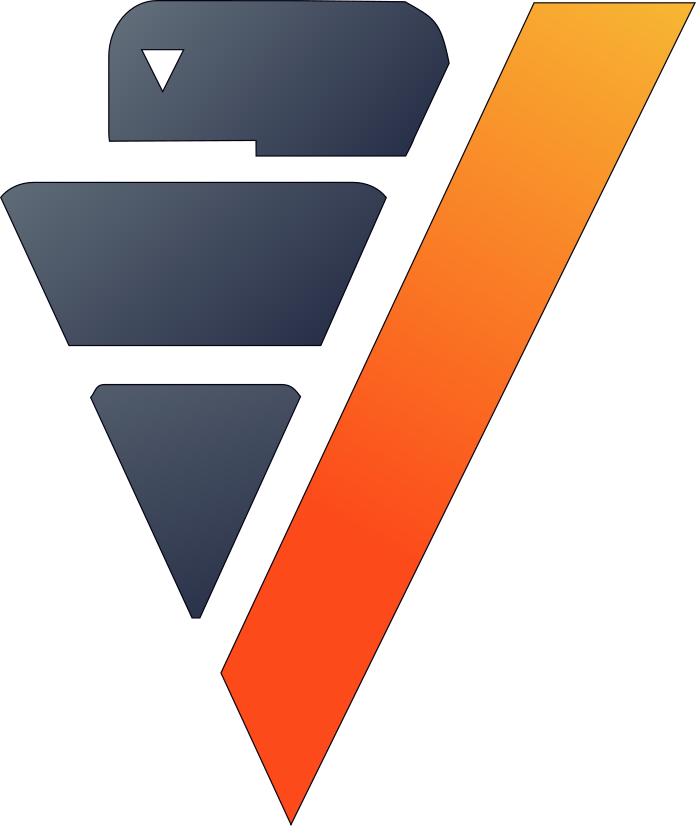

In [18]:
data_forPreds

## CREATE VIEW OF  recent model predictions to vertica database


# WILL NEED TO EITHER DROP DUPLICATES OR CHOOSE ROW WITH MAX DateOfPredictions by DATA_SOURCE, CLIENT MEMBER_ID, EPI_ID

https://www.vertica.com/python/workshop/data_prep/duplicates/


https://www.vertica.com/python/documentation_last/vdataframe/main-methods/drop_duplicates/

In [19]:
#see sql used to create the model scores from model input data (& cleaning)
print(data_forPreds.current_relation())

(
   SELECT
     "MEMBER_AGE",
     "SCOPE_FLAG",
     "EPI_ADMIT_TYPE",
     "EPI_IS_READMIT_30_DAY",
     "EPI_IS_READMIT_90_DAY",
     "EPI_HOS_HAS_COVID",
     "EPI_IS_READMIT_W_COVID_90",
     "EPI_ID_READMIT_RISK_R",
     "EPI_ID_DRG_WEIGHTS",
     "COVID_START_FLAG",
     "Latitude",
     "Longitude",
     "HAS_ONSITE",
     "DRG_WEIGHT",
     "MCG_30THPERCENTILE",
     "MCG_40THPERCENTILE",
     "READMIT_RISK_R",
     "DAYS",
     "PRIOR_EPI_ADMIT_TYPE",
     "HAS_CENSUS",
     "HAS_ADT",
     "HAS_AUTH",
     "Readmit_90",
     "MEMBER_DAYS",
     "MEMBER_DAYS_AddOne",
     "MEMBER_MONTHS",
     "MEMBER_MONTHS_AddOne",
     "flu_flag",
     "awv_flag",
     "Office_Visit_Frequency",
     "flu_counts",
     "awv_counts",
     "Office_Visit_Counts",
     "flu_byMemMonths",
     "awv_byMemMonths",
     "ofv_byMemMonths",
     "flu_byMemDays",
     "awv_byMemDays",
     "ofv_byMemDays",
     "flu_counts_recent",
     "awv_counts_recent",
     "Office_Visit_Counts_recent",
     "fl

In [20]:
len(data_forPreds)

4360

In [21]:
#drop current view
drop(name='"DATALAB_WORK_PRD"."HomeFirst_Model_Outputs"', cursor=cur, method='view')


True

MEMBER_AGE    SCOPE_FLAG    EPI_ADMIT_TYPE    EPI_IS_READMIT_30_DAY   \\
1            79.0             1                 9                        0   \\
2            73.0             1                 9                        0   \\
3            69.0             1                 9                        0   \\
4            80.0             1                 9                        0   \\
5            42.0             1                 9                        0   \\
6            81.0             1                 9                        0   \\
7            53.0             1                 9                        0   \\
8            63.0             1                 9                        0   \\
9            75.0             1                 9                        0   \\
10           63.0             1                 9                        0   \\
11           64.0             1                 9                        0   \\
12           92.0             1                 9                        0   \\
13           69.0             1                 9                        0   \\
14           67.0             1                 9                        1   \\
15           57.0             1                 9                        0   \\
16           73.0             1                 9                        1   \\
17           69.0             1                 9                        0   \\
18           47.0             1                 9                        0   \\
19           75.0             1                 9                        0   \\
20           90.0             1                 9                        0   \\
21           65.0             1                 9                        1   \\
22           76.0             1                 9                        0   \\
23           81.0             1                 9                        1   \\
24           78.0             1                 9                        1   \\
25           69.0             1                 9                        0   \\
26           74.0             1                 9                        0   \\
27           64.0             1                 9                        0   \\
28           79.0             1                 9                        0   \\
29           73.0             1                 9                        0   \\
30           79.0             1                 9                        0   \\
31           67.0             1                 9                        1   \\
32           58.0             1                 9                        0   \\
33           65.0             1                 9                        0   \\
34           52.0             1                 9                        0   \\
35           76.0             1                 9                        0   \\
36           72.0             1                 9                        0   \\
37           81.0             1                 9                        0   \\
38           56.0             1                 9                        0   \\
39           71.0             1                 9                        1   \\
40           71.0             1                 9                        0   \\
41           62.0             1                 9                        0   \\
42           74.0             1                 9                        0   \\
43           70.0             1                 9                        0   \\
44           85.0             1                 9                        0   \\
45           80.0             1                 9                        0   \\
46           73.0             1                 9                        0   \\
47           51.0             1                 9                        0   \\
48           51.0             1                 9                        0   \\
49           69.0             1                 9                        0   \\
50     
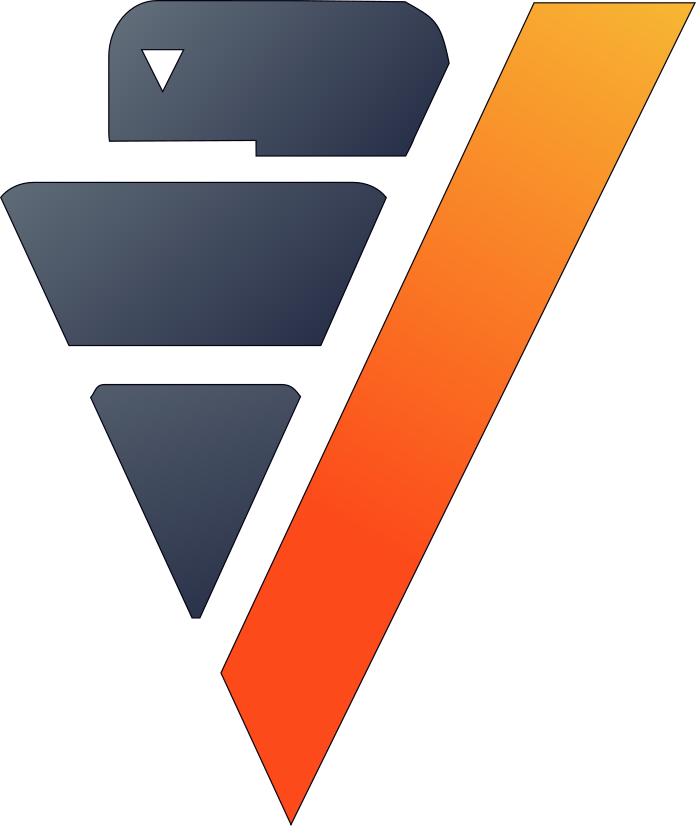

In [22]:
# Display sql queries
set_option("sql_on", True)
#save model outputs to view
#for  patients' that are currently in HOS (or are missing reccommendations) 
data_forPreds.to_db(name='"DATALAB_WORK_PRD"."HomeFirst_Model_Outputs"', 
                    usecols=['DATA_SOURCE',   'MEMBER_ID', 'CLIENT','EPI_ID',"Readmission_Likelihood", "SNF_Discharge_Likelihood",
                             "pred_Home_RA", "pred_SNF_RA",'ChangeIfHome','zscore','Recommendation', 'DateOfPredictions'], relation_type='view')

# OLD WAY

In [23]:
'''
# Display queries and their execution times
set_option("sql_on", True)
#save model outputs
data_forPreds.to_db(name='"MEDECON_PRD"."HomeFirst_Model_Outputs"', 
                    usecols=['DATA_SOURCE',  'CLIENT', 'MEMBER_ID', 'EPI_ID',"Readmission_Likelihood", "SNF_Discharge_Likelihood",
                             "pred_Home_RA", "pred_SNF_RA",'ChangeIfHome','zscore','Recommendation', 'DateOfPredictions'], relation_type='insert')
                             
'''

'\n# Display queries and their execution times\nset_option("sql_on", True)\n#save model outputs\ndata_forPreds.to_db(name=\'"MEDECON_PRD"."HomeFirst_Model_Outputs"\', \n                    usecols=[\'DATA_SOURCE\',  \'CLIENT\', \'MEMBER_ID\', \'EPI_ID\',"Readmission_Likelihood", "SNF_Discharge_Likelihood",\n                             "pred_Home_RA", "pred_SNF_RA",\'ChangeIfHome\',\'zscore\',\'Recommendation\', \'DateOfPredictions\'], relation_type=\'insert\')\n                             \n'

# TO DROP DUPLICATES
# FINAL SQL would be (make into view or static table??)

DROP TABLE IF EXISTS test_this;
CREATE LOCAL TEMP TABLE test_this ON COMMIT PRESERVE ROWS AS 
  SELECT 
--COUNT(*)
a.*,
b.Readmission_Likelihood, 
b.SNF_Discharge_Likelihood,
b.pred_Home_RA, 
b.pred_SNF_RA,
b.ChangeIfHome,
b.zscore,
b.Recommendation

FROM (
    SELECT
    DATA_SOURCE, MEMBER_ID, EPI_ID,
    MAX(DateOfPredictions) AS DateOfPredictions
    FROM MEDECON_PRD.HomeFirst_Model_Outputs
    GROUP BY 1,2,3
) a
LEFT JOIN MEDECON_PRD.HomeFirst_Model_Outputs b
USING(DATA_SOURCE, MEMBER_ID, EPI_ID,DateOfPredictions)

;

In [24]:
#shut this off
set_option("sql_on", False)

In [25]:
#get end time and run time duration
NBend_time = time.time()
NBrun_time = NBend_time - NBstart_time 

In [26]:
print('total notebook run of ',len(data_forPreds), 'rows took', round(NBrun_time/60,1), 'mins')
print('this is ',round(len(data_forPreds)/(NBrun_time/60),1), 'rows per min')

total notebook run of  4360 rows took 0.4 mins
this is  11351.4 rows per min



# then filter the full data down again to 5 months prior to PTD again for analysis
#https://www.vertica.com/python/documentation_last/vdataframe/main-methods/filter/index.php 
# OR use search again and change variable names in analysis below

In [20]:
%%time
#load all patient homefirst pred data 

%%time
#load all patient homefirst pred data 
Preds_curr = vdf_from_relation("(SELECT * FROM MEDECON_PRD.HomeFirst_Model_Outputs) x",
                cursor=cur)

#Preds_curr = vdf_from_relation("(SELECT a.*, b.CLIENT FROM MEDECON_PRD.HomeFirst_Model_Outputs a LEFT JOIN MEDECON_PRD.PDM b USING(DATA_SOURCE, MEMBER_ID, EPI_ID)) x",
 #               cursor=cur)

Wall time: 3.08 s


count    percent  
"DATA_SOURCE"                   319075.0      100.0  
"MEMBER_ID"                     319075.0      100.0  
"EPI_ID"                        319075.0      100.0  
"Readmission_Likelihood"        319075.0      100.0  
"SNF_Discharge_Likelihood"      319075.0      100.0  
"pred_Home_RA"                  319075.0      100.0  
"pred_SNF_RA"                   319075.0      100.0  
"ChangeIfHome"                  319075.0      100.0  
"zscore"                        319075.0      100.0  
"Recommendation"                319075.0      100.0  
"DateOfPredictions"             319075.0      100.0  
"CLIENT"                        192253.0     60.253  
Rows: 1-12 | Columns: 3
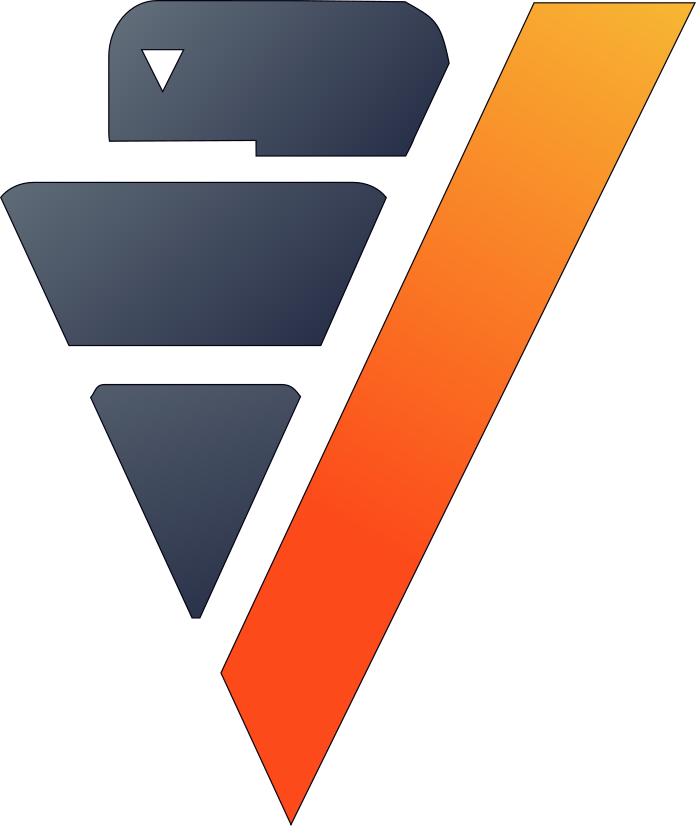

In [21]:
Preds_curr.count()

In [22]:
#create numerical column for Recommendation
Preds_curr['RecommendationBinary'] = st.case_when(Preds_curr['Recommendation']=='Home', 1,0)

DATA_SOURCE      CLIENT      home_recc_prcnt    counts  
1    OPERATIONAL        None    0.924019491886266    126822  
2          CLAIM     HORIZON     0.97120498166355     95711  
3          CLAIM      OPTIMA    0.975547370574995     39096  
4          CLAIM    WELLCARE    0.929741399540057     42614  
5          CLAIM    AMBETTER    0.951793419633226     14832  
Rows: 1-5 | Columns: 4
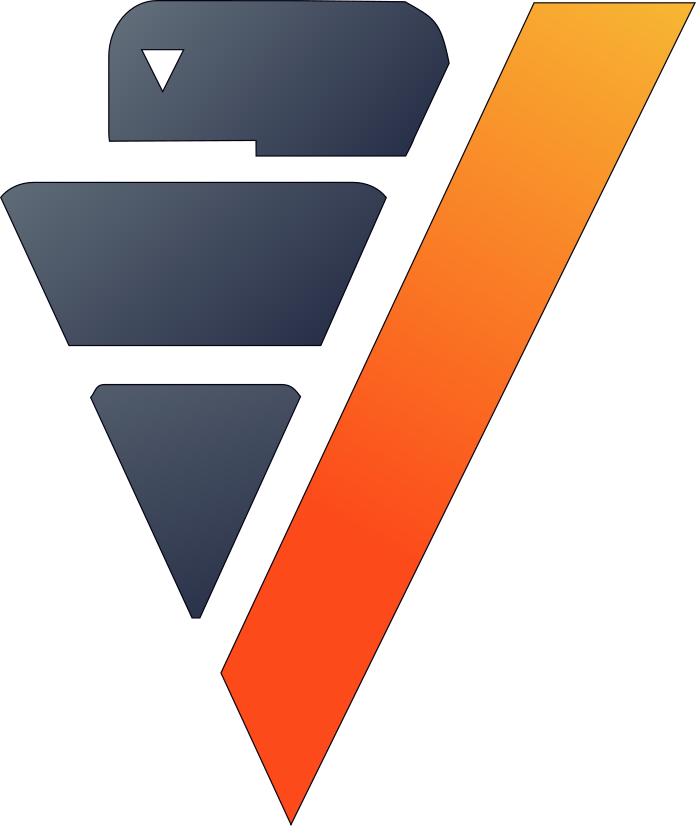

In [25]:
#group by data source and client and see percent recommneded home
#could rolloup stay month here
Preds_curr.groupby(columns = ["DATA_SOURCE", "CLIENT"],
               expr = ["ROUND(AVG(RecommendationBinary)*100,2) AS home_recc_prcnt", "COUNT(*) AS counts"]).sort(columns='CLIENT')

In [ ]:
#COULD POSSIBLY USE AUC OR ACTUAL SQL to rolloup with groupby?
#https://www.vertica.com/docs/9.2.x/HTML/Content/Authoring/SQLReferenceManual/Functions/MachineLearning/ROC.htm
#https://www.vertica.com/python/documentation-0.5.0/learn/metrics/auc/index.php


In [ ]:
#create numerical column for Recommendation
data_forPreds['RecommendationBinary'] = st.case_when(data_forPreds['Recommendation']=='Home', 1,0)

In [ ]:
#data_forModel.filter(["PERIOD <= ADD_MONTHS(PAID_THRU_DATE, -5)"])
#data_forModel.search(conditions = ["PERIOD <= ADD_MONTHS(PAID_THRU_DATE, -5)"])

dtype  
"MEMBER_AGE"                                       float  
"SCOPE_FLAG"                                         int  
"EPI_ADMIT_TYPE"                                     int  
"EPI_IS_READMIT_30_DAY"                              int  
"EPI_IS_READMIT_90_DAY"                              int  
"EPI_HOS_HAS_COVID"                                  int  
"EPI_IS_READMIT_W_COVID_90"                          int  
"EPI_ID_READMIT_RISK_R"                            float  
"EPI_ID_DRG_WEIGHTS"                               float  
"COVID_START_FLAG"                                   int  
"Latitude"                                         float  
"Longitude"                                        float  
"HAS_ONSITE"                                         int  
"DRG_WEIGHT"                                       float  
"MCG_30THPERCENTILE"                               float  
"MCG_40THPERCENTILE"                               float  
"READMIT_RISK_R"                                   float  
"DAYS"                                               int  
"PRIOR_EPI_ADMIT_TYPE"                               int  
"HAS_CENSUS"                                         int  
"HAS_ADT"                                            int  
"HAS_AUTH"                                           int  
"Readmit_90"                                         int  
"MEMBER_DAYS"                                        int  
"MEMBER_DAYS_AddOne"                                 int  
"MEMBER_MONTHS"                                      int  
"MEMBER_MONTHS_AddOne"                               int  
"flu_flag"                                           int  
"awv_flag"                                           int  
"Office_Visit_Frequency"                             int  
"flu_counts"                                         int  
"awv_counts"                                         int  
"Office_Visit_Counts"                                int  
"flu_byMemMonths"                         numeric(36,18)  
"awv_byMemMonths"                         numeric(36,18)  
"ofv_byMemMonths"                         numeric(36,18)  
"flu_byMemDays"                           numeric(36,18)  
"awv_byMemDays"                           numeric(36,18)  
"ofv_byMemDays"                           numeric(36,18)  
"flu_counts_recent"                                  int  
"awv_counts_recent"                                  int  
"Office_Visit_Counts_recent"                         int  
"flu_byMemMonths_recent"                  numeric(36,18)  
"awv_byMemMonths_recent"                  numeric(36,18)  
"ofv_byMemMonths_recent"                  numeric(36,18)  
"flu_byMemDays_recent"                    numeric(36,18)  
"awv_byMemDays_recent"                    numeric(36,18)  
"ofv_byMemDays_recent"                    numeric(36,18)  
"total_admit_count_CLAIMS"                         float  
"total_admit_count_OPS"                            float  
"total_admit_count_byMemMonths_CLAIMS"             float  
"total_admit_count_byMemMonths_OPS"                float  
"total_admit_count_byMemDays_CLAIMS"               float  
"total_admit_count_byMemDays_OPS"                  float  
"hist_readmit_90_rate_byMemMonths_CLA...           float  
"hist_readmit_90_rate_byMemMonths_OPS"             float  
"hist_readmit_90_rate_byMemDays_CLAIMS"            float  
"hist_readmit_90_rate_byMemDays_OPS"               float  
"Streak_flag_CLAIMS"                                 int  
"Streak_flag_OPS"                                    int  
"grouping_noReadmitsMAX_CLAIMS"                    float  
"grouping_noReadmitsMAX_OPS"                         int  
"Streak_90_CLAIMS"                                 float  
"Streak_90_OPS"                                    float  
"No_Streak_CLAIMS"                                   int  
"No_Streak_OPS"                                      int  
"Count_180_CLAIMS"                                 float  
"Count_180_OPS"                        
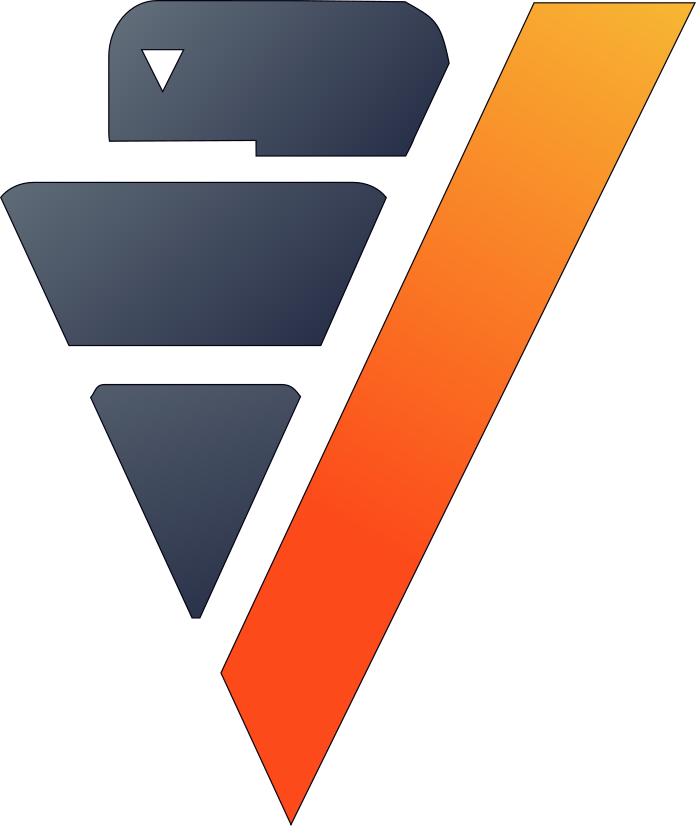

In [216]:
data_forModel.dtypes()

In [232]:
#name columns to convert to float
vc_toFloat = ["Readmission_Likelihood", "SNF_Discharge_Likelihood", "pred_Home_RA", "pred_SNF_RA"]
for vc in vc_toFloat:
    print('converting column to float - ', vc)
    data_forModel[vc].astype('float')

MEMBER_AGE    SCOPE_FLAG    EPI_ADMIT_TYPE    EPI_IS_READMIT_30_DAY   \\
1      58.1238084599345             1                 9                        0   \\
2                  59.0             1                 9                        0   \\
3      58.1238084599345             1                 9                        0   \\
4                  43.0             1                 9                        0   \\
5      58.1238084599345             1                 9                        1   \\
6                  31.0             1                 9                        0   \\
7                  50.0             1                 9                        0   \\
8                  51.0             1                 3                        0   \\
9                  48.0             1                 9                        0   \\
10                 47.0             1                 9                        0   \\
11                 57.0             1                 9                        0   \\
12     58.1238084599345             1                 9                        0   \\
13     58.1238084599345             1                 9                        0   \\
14                 42.0             1                 1                        0   \\
15                  7.0             1                 9                        0   \\
16                 44.0             1                 9                        0   \\
17                 73.0             1                 9                        0   \\
18     58.1238084599345             1                 9                        0   \\
19     58.1238084599345             1                 9                        0   \\
20                 83.0             1                 9                        0   \\
21                 68.0             1                 9                        0   \\
22                 68.0             1                 9                        1   \\
23                 71.0             1                 9                        0   \\
24                 57.0             1                 9                        0   \\
25     58.1238084599345             1                 9                        0   \\
26                 61.0             1                 9                        1   \\
27                 38.0             1                 9                        0   \\
28                 78.0             1                 9                        0   \\
29                 47.0             1                 1                        0   \\
30                 36.0             1                 9                        0   \\
31                 47.0             1                 9                        0   \\
32                 29.0             1                 9                        0   \\
33                 45.0             1                 9                        0   \\
34                 36.0             1                 9                        0   \\
35     58.1238084599345             1                 9                        0   \\
36                 53.0             1                 9                        0   \\
37                 33.0             1                 9                        0   \\
38                 25.0             1                 9                        0   \\
39                 31.0             1                 9                        0   \\
40                 49.0             1                 9                        0   \\
41     58.1238084599345             1                 9                        1   \\
42     58.1238084599345             1                 9                        0   \\
43                 81.0             1                 1                        0   \\
44                 57.0             1                 9                        0   \\
45     58.1238084599345             1                 9                        0   \\
46                 31.0             1                 9  
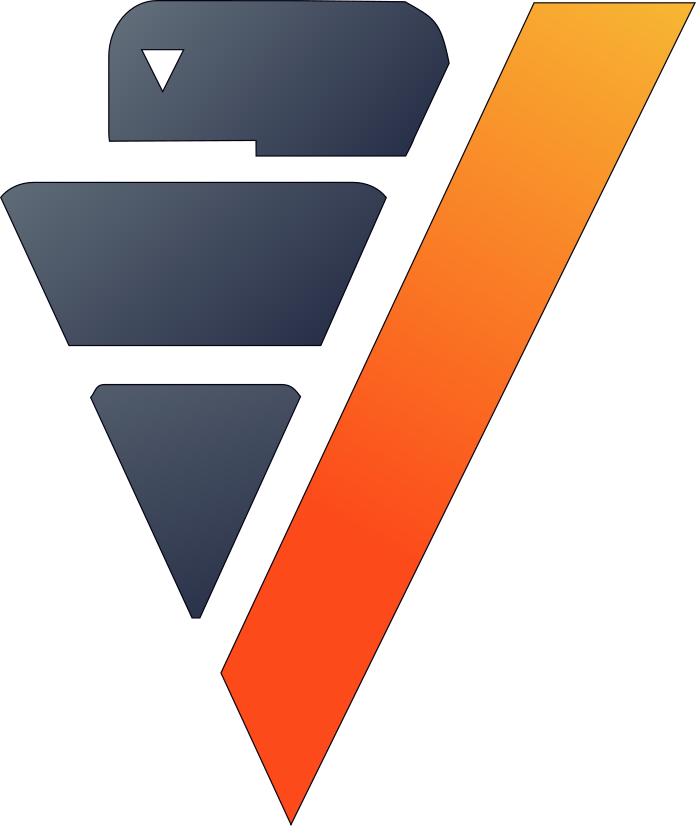

In [233]:
data_forModel

value  
name        "Recommendation"  
dtype             varchar(4)  
unique                   2.0  
count                30000.0  
Home                   28636  
SNF                     1364  
Rows: 1-6 | Columns: 2
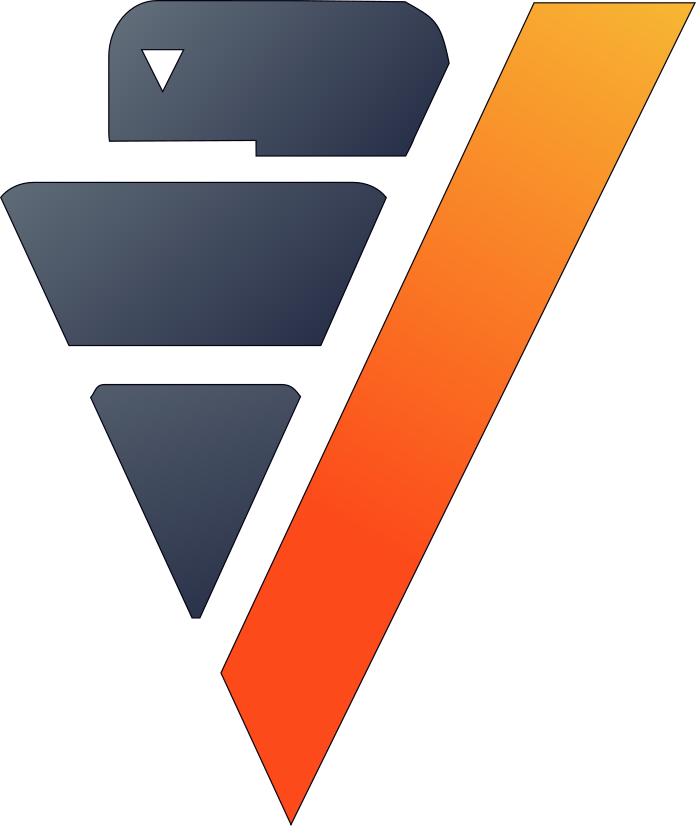

In [214]:
data_forModel.Recommendation.value_counts()

count                    mean                  std                  min   \\
"ChangeIfHome"              30000     -0.0555068975666668    0.104495534675741            -0.669557   \\
"Readmit_90"                30000       0.173266666666667    0.378483954603564                    0   \\
"zscore"                    30000    -0.00434004800065038    0.994618696753101    -5.84904637462548   \\
"RecommendationBinary"      30000       0.954600000000003    0.208183295862458                    0   \\
"pred_Home_RA"              30000       0.170656753204666     0.17582846050131           0.00833011   \\
"pred_SNF_RA"               30000       0.225817255676667    0.154166690679631            0.0887769   \\
                                          25%                    50%                  75%   \\
"ChangeIfHome"                     -0.0857168    -0.0725596641025641           -0.0246499   \\
"Readmit_90"                                0                      0                    0   \\
"zscore"                    -0.29188662958923     -0.166653207894043      0.2893657720682   \\
"RecommendationBinary"                      1                      1                    1   \\
"pred_Home_RA"                      0.0207395              0.1394882    0.216445256410256   \\
"pred_SNF_RA"                        0.105383      0.171933971014493    0.272157285714286   \\
                                         max    unique  
"ChangeIfHome"                      0.603786    9881.0  
"Readmit_90"                               1       2.0  
"zscore"                    6.27100027722154    9890.0  
"RecommendationBinary"                     1       2.0  
"pred_Home_RA"                      0.936836    4595.0  
"pred_SNF_RA"                       0.914844    4548.0  
Rows: 1-6 | Columns: 10
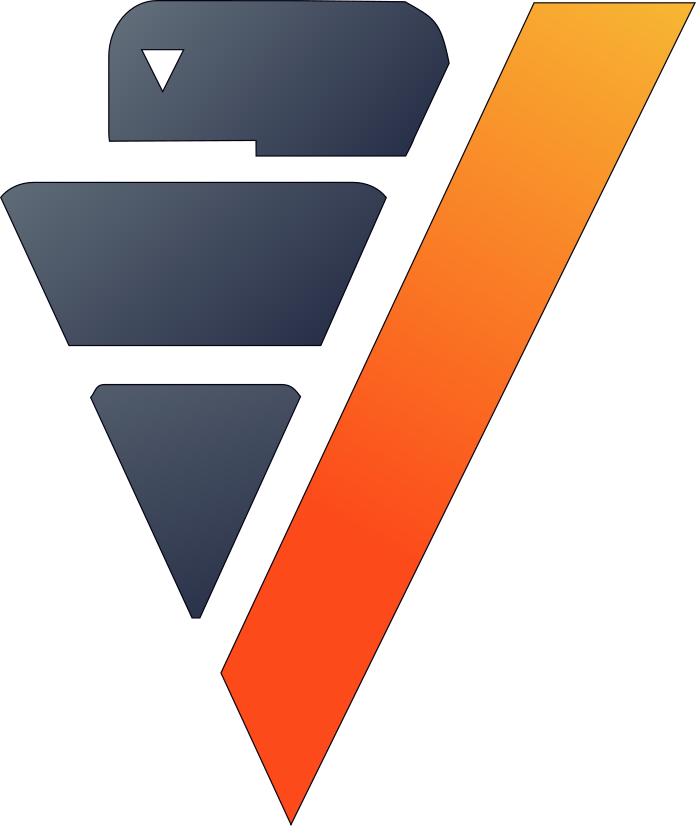

In [234]:
#define col of interest
col_int = ['pred_SNF_RA', 'pred_Home_RA', 
           'ChangeIfHome',
   #'Recommendation',
   #'Discharge_Home', 
           'Readmit_90', 'zscore', 'RecommendationBinary']

#look at summary stats for those columns of interest
data_forModel.describe(columns=col_int)

# Keep working here for analysis...

In [ ]:

#create dataframe with only cols of interest
#df_int = claims_data[col_int]
df_int = dataModels_norm[col_int]
#create column that has only home/snf for actual discharges 
df_int['Discharge_Home_name'] = np.where(df_int['Discharge_Home']==1, 'Home', 'SNF')
#create followed poc variable so it is correct
df_int['FollowedPoC'] = np.where(df_int.Recommendation==df_int.Discharge_Home_name, 'Followed', 'Did Not Follow')

#generate recommendation summary stats
cl_list = []
#get sum of all readmits divided by count of all patients (split by if followed poc or not)
fpoc_RR = df_int.groupby('FollowedPoC').sum()['Readmit_90']/df_int.groupby('FollowedPoC').count()['Readmit_90']
#get followed POC vs not RR %s
f_RR = fpoc_RR['Followed']
dnf_RR = fpoc_RR['Did Not Follow']

#get difference in followed poc readmit rate - did not follow poc readmit rate
diff = fpoc_RR['Followed']-fpoc_RR['Did Not Follow']
#print('Difference in Readmit Rates',diff)
#get percent change of the readmit rates if followed vs not followed poc readmit rate
diff_chng = diff/np.abs(fpoc_RR['Did Not Follow'])
#print('Percentage Change in Readmit Rates',diff_chng)
#get percent difference of the readmit rates if followed vs not followed poc readmit rate
diff_prct = np.abs(fpoc_RR['Did Not Follow']-fpoc_RR['Followed'])/((fpoc_RR['Did Not Follow']+fpoc_RR['Followed'])/2)
#print('Percentage Difference in Readmit Rates',diff_prct)
#get sum of all readmits divided by count of all patients (split by RECCOMENDATION AND if followed poc or not)
fpoc_RR_byRecc = df_int.groupby(['Recommendation', 'FollowedPoC']).sum()['Readmit_90']/df_int.groupby(['Recommendation', 'FollowedPoC']).count()['Readmit_90']
#get home recc RR scores
f_RR_Home = fpoc_RR_byRecc['Home']['Followed'] 
dnf_RR_Home = fpoc_RR_byRecc['Home']['Did Not Follow']
#get snf reccRR scores
f_RR_SNF = fpoc_RR_byRecc['SNF']['Followed']
dnf_RR_SNF = fpoc_RR_byRecc['SNF']['Did Not Follow']

#get difference in followed poc readmit rate - did not follow poc readmit rate
#for snf/home reccs
diff_snf =  f_RR_SNF - dnf_RR_SNF
diff_home =  f_RR_Home - dnf_RR_Home
#get percent change of the readmit rates if followed vs not followed poc readmit rate
#for snf/home reccs
diff_chng_SNF = diff_snf/np.abs(dnf_RR_SNF)
diff_chng_Home = diff_home/np.abs(dnf_RR_Home)
#get percent difference of the readmit rates if followed vs not followed poc readmit rate
#for snf/home reccs
diff_prct_snf = np.abs(dnf_RR_SNF-f_RR_SNF)/((dnf_RR_SNF+f_RR_SNF)/2)
diff_prct_home = np.abs(dnf_RR_Home-f_RR_Home)/((dnf_RR_Home+f_RR_Home)/2)


#get % discharged to home
home_dis_prct =  df_int['Recommendation'].tolist().count('Home')/len(df_int)
##append all to list
cl_list.append([f_RR, dnf_RR, diff, diff_chng, diff_prct, home_dis_prct, f_RR_Home,dnf_RR_Home, f_RR_SNF, dnf_RR_SNF,
             diff_snf,diff_home , diff_chng_SNF,diff_chng_Home,diff_prct_snf,diff_prct_home ]) 

#create dataframe
poc_RRdiffs = pd.DataFrame(cl_list, columns=['RR_FolPOC', 'RR_NotFolPOC','RR_diff', 'RR_prcnt_change', 'RR_prcnt_diff',
    'home_dischr_prct', 'RR_FolPOC_Home', 'RR_NotFolPOC_Home','RR_FolPOC_SNF', 'RR_NotFolPOC_SNF',
     'RR_diff_SNF', 'RR_diff_Home','RR_prcnt_change_SNF', 'RR_prcnt_change_Home','RR_prcnt_diff_SNF','RR_prcnt_diff_Home'])


#get col of interest for POC recc data
#multiply probablity by 100 to make percentage (and match other data)
RRdiffs_int = poc_RRdiffs[['RR_prcnt_change','home_dischr_prct','RR_prcnt_change_SNF','RR_prcnt_change_Home']]*100

#add POC recommendation evaluation data to corr_eval data 
SNF_Home_corr_eval.loc[SNF_Home_corr_eval.index[0], list(RRdiffs_int.columns)] = RRdiffs_int.values.tolist()[0]


#get end time and run time duration
end_time = time.time()
run_time = end_time - start_time 
print('Duration in secs:', round(run_time, 2)) #print for visual control
print('\n')

# Summary